# Outbreak size in the SIR model (Kermack-McKendrick relation)

We move next to the Susceptible-Infected-Recovered model, the first of these canonical test models that actually provides a decent, coarse, representation of many vaccine-preventable diseases that we are interested in.  This test will explore the size of acute outbreaks; in this situation, the role of demography is pretty small and serves only to complicate the analysis, so we will work without demography.  The model contains three agent states and two transitions: susceptible -> infected -> recovered, with the recovered state assumed to be lifelong.

$$
\dot{S} = -\frac{\beta*S*I}{N} \\

\dot{I} = \frac{\beta*S*I}{N} - \gamma I \\

\dot{R} = \gamma I
$$

As before, we discretize this as:
$$
\Delta I = Bin(S_t, 1-exp^{-\beta \Delta t \frac{I}{N}}) \\
\Delta R = Bin(I_t, 1-exp^{-\gamma \Delta t}) \\
S_{t+1} = S_t - \Delta I_t \\
I_{t+1} = I_t + \Delta I_t -\Delta R_t \\
R_{t+1} = R_t + \Delta R_t
$$

Note: As written, the dwell time of individuals in the infectious state is strictly exponentially distributed.  Without introducing substantially more complexity (delay-differential or integro-differential equations, the Generalized Linear Chain Trick), this is a general feature of ODE systems.  In agent-based models, however, the distribution of the dwell time in the Infectious state can be chosen from an arbitrary distribution, in which case the discretization as written no longer holds.  For the purposes of comparability with analytic results, we choose to draw from an exponential distribution in the below.

Analysis of the SIR system can be found in other sources, and closed-form analytic solutions to the system dyanmics are elusive and generally too complicated to provide much insight - more generally useful are results about the equilibrium states as  $t \rightarrow \infty$.  We'll focus here on one of these, the size of an outbreak introduced into a closed population, given by the implicit formula

$$ 
Z = 
\begin{cases}
    S_0(1-e^{-R_0[Z+I_0]}), & \text{if} \:\:  R_0S(0)>1 \\
    0, &\text{if} \:\:  R_0S(0)<=1
\end{cases} \\
Z = \sum_{t=0}^\infty I(t) = S_0 - S_\infty \\
R_0 = \frac{\beta}{\gamma}
$$

One can obtain an approximate analytic solution for the outbreak curve itself, shown below. However, the approximation employed in deriving this is that $R_0 R(t)$ is small, which likely to be violated during the peak of the outbreak.  And it's immediately clear upon looking at this formula that it doesn't exactly offer some intuitive interpretation for the dynamics.

$$
\frac{dR}{dt} = \frac{\gamma \alpha^2}{2S(0)R_0^2}\text{sech}^2\left(\frac{\alpha \gamma t}{2} - \phi\right) \\
\phi = \text{tanh}^{-1}\left(\frac{S(0)(R_0-1)}{\alpha}\right) \\
\alpha = \sqrt{S(0)^2(R_0-1)^2 + 2S(0)I(0)R_0^2}
$$


This notebook will focus on testing the final size prediction and for now, ignore testing the approximate formula for the whole outbreak curve.

### Contruct the model

In the first few cells, we do all the necessary imports.  Then we construct a single-patch LASER model with four components: the states `Susceptible`, `Recovered`, and `Infectious`, and the `Transmission` process.  The `Susceptible` and `Transmission` components look largely the same as the SI and SIS models.  The `Infectious` component now moves people into a `Recovered` state when `itimer` expires, instead of sending them back to `Susceptible` as in the SIS model.  As there are no vital dynamics in this model, the `Recovered` state is a terminal state - these agents have no further dynamics and participate only by being part of the total population denominator in the `Transmission` component. 

### Sanity check

The first test, as always, ensures that certain basic constraints are being obeyed by the model.  We can check that $S_t = N_t - \sum{\Delta I_t}$, that $R_t = \sum{\Delta R_t}$, and the total population is constant and equal to $S_t + I_t + R_t$ for all timesteps.

### Scientific test

The scientific test will loop over a set of $(R_0, S(0))$ pairs and confirm that the final outbreak size matches the expectation given in the equation above.  As this is a stochastic model, the main concern is that when $R_0S(0)$ is close to one, the outbreak may fail to take off or truncate at a slightly smaller final size.  



In [1]:
import itertools

import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
from laser_core.demographics import AliasedDistribution
from laser_core.demographics import KaplanMeierEstimator
from laser_core.propertyset import PropertySet
from scipy.optimize import fsolve
from scipy.special import lambertw

import laser_core
import laser_generic
import laser_core.distributions as dists
from laser_generic.models import SIR
from laser_generic.newutils import ValuesMap
from laser_generic.newutils import grid

print(f"{np.__version__=}")
print(f"{laser_core.__version__=}")
print(f"{laser_generic.__version__=}")


np.__version__='2.3.4'
laser_core.__version__='0.6.0'
laser_generic.__version__='0.0.0'


In [2]:
def create_single_node_model(population: int, init_inf: int = 0, init_rec: int = 0, parameters: PropertySet = None) -> SIR.Model:

    scenario = grid(M=1, N=1, node_size_km=10, population_fn=lambda x,y: population, origin_x=0, origin_y=0)
    scenario["S"] = scenario.population - (init_inf + init_rec)
    assert np.all(scenario["S"] >= 0), "Initial susceptible population cannot be negative."
    scenario["I"] = init_inf
    scenario["R"] = init_rec

    params = parameters or PropertySet({"seed": 20251017, "nticks": 365, "beta": 4.0/3.0, "inf_mean": 7.0, "cbr": 0.0, "cdr": 0.0})
    for key in ["beta", "inf_mean"]:
        assert key in params, f"Parameter '{key}' must be specified."

    model = SIR.Model(scenario, params)

    infdurdist = dists.exponential(scale=params.inf_mean)

    model.components = [SIR.Susceptible(model), SIR.Recovered(model), SIR.Infectious(model, infdurdist), SIR.Transmission(model, infdurdist)]

    return model

Running Simulation SIR Model: 100%|██████████| 730/730 [00:00<00:00, 739.65it/s] 


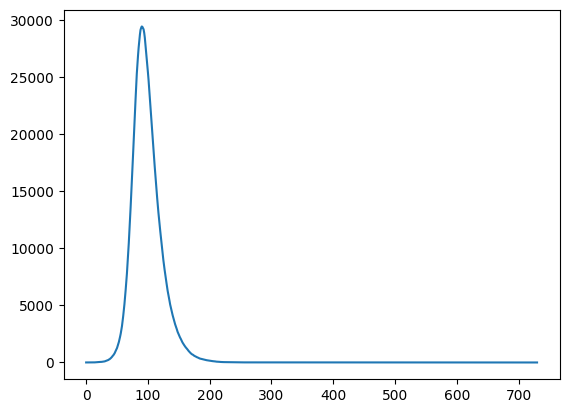

In [3]:
pop = 1e5
initial_infected = 3
# R0 = beta * inf_mean = 0.2 * 15 = 3.0 - expected attack fraction is just under 80%
parameters = PropertySet({"seed": 2, "nticks": 730, "verbose": True, "beta": 0.2, "inf_mean": 15})

# Run simulations until we get an outbreak
outbreak = False
while not outbreak:

    parameters.seed += 1
    model = create_single_node_model(
        population=pop,
        init_inf=initial_infected,
        init_rec=0,
        parameters=parameters,
    )

    model.run()
    outbreak = np.any(model.nodes.R[200] >= 10)

plt.plot(model.nodes.I)

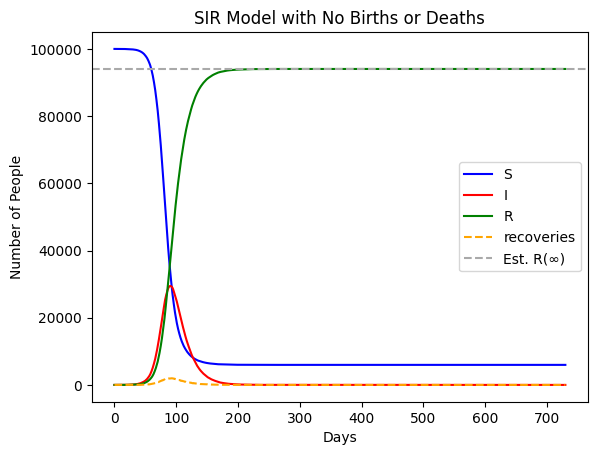

In [4]:
# Estimate the outbreak size (attack fraction) using the final size equation
R0 = parameters.beta * parameters.inf_mean
S0 = (pop - initial_infected) / pop
S_inf = -1 / R0 * lambertw(-R0 * S0 * np.exp(-R0)).real
A = 1 - S_inf  # Attack fraction
final_R = A * pop + initial_infected

plt.plot(model.nodes.S, color="blue")
plt.plot(model.nodes.I, color="red")
plt.plot(model.nodes.R, color="green")
plt.plot(model.nodes.recovered, color="orange", linestyle="dashed")
plt.axhline(final_R, color="darkgray", linestyle="dashed")
plt.legend(["S", "I", "R", "recoveries", "Est. R(∞)"])
plt.xlabel("Days")
plt.ylabel("Number of People")
plt.title("SIR Model with No Births or Deaths")
plt.show()


# Sanity checks
Check that the expected relationships between susceptible, infected, recovered, and total population hold.

In [5]:
print("S+I+R = N:  " + str(np.isclose(model.nodes.S + model.nodes.I + model.nodes.R, pop).all()))
print("S = N - sum(deltaI): " + str(np.isclose(pop - np.squeeze(model.nodes.S)[1:], initial_infected+np.cumsum(model.nodes.incidence)[:-1]).all()))  # Account for 1 timestep offset here
print("R = sum(deltaR): " + str(np.isclose(np.squeeze(model.nodes.R)[1:], np.cumsum(model.nodes.recovered)[:-1]).all()))  # Account for 1 timestep offset here


S+I+R = N:  True
S = N - sum(deltaI): True
R = sum(deltaR): True


## Scientific test
We will now loop over a few values of R-zero and initial susceptibility, and compare the size of the outbreak against the expected size given by the equation in the introduction

In [6]:
def KM_limit(z, R0, S0, I0):
    if R0 * S0 < 1:
        return 0
    else:
        return z - S0 * (1 - np.exp(-R0 * (z + I0)))

In [7]:
# %%capture

population = 1e5
inf_mean = 20
init_inf = 20

R0s = np.concatenate((np.linspace(0.2, 1.0, 5), np.linspace(1.5, 10.0, 18)))
S0s = [1.0, 0.8, 0.6, 0.4, 0.2]
output = pd.DataFrame(list(itertools.product(R0s, S0s)), columns=["R0", "S0"])
output["I_inf_exp"] = [
    fsolve(KM_limit, 0.5 * (R0 * S0 >= 1), args=(R0, S0, init_inf / population))[0] for R0, S0 in zip(output["R0"], output["S0"])
]
output["S_inf_exp"] = output["S0"] - output["I_inf_exp"]
output["I_inf_obs"] = np.nan
output["S_inf_obs"] = np.nan


for index, row in output.iterrows():

    parameters = PropertySet({"seed": 2, "nticks": 1460, "verbose": True, "inf_mean": inf_mean, "beta": row["R0"] / inf_mean})
    model = create_single_node_model(
        population=population,
        init_inf=init_inf,
        init_rec=int((1 - row["S0"]) * population),
        parameters=parameters,
    )

    model.run(f"SIR Model {index+1:3}/{len(output)}")

    output.loc[index, "I_inf_obs"] = (
        np.sum(model.nodes.incidence) + init_inf
    ) / population  # incidence doesn't count the imported infections
    output.loc[index, "S_inf_obs"] = model.nodes.S[-1] / population

Running Simulation SIR Model 115/115: 100%|██████████| 1460/1460 [00:00<00:00, 1781.73it/s]


Text(0.5, 1.0, 'S Expected - Observed v R0')

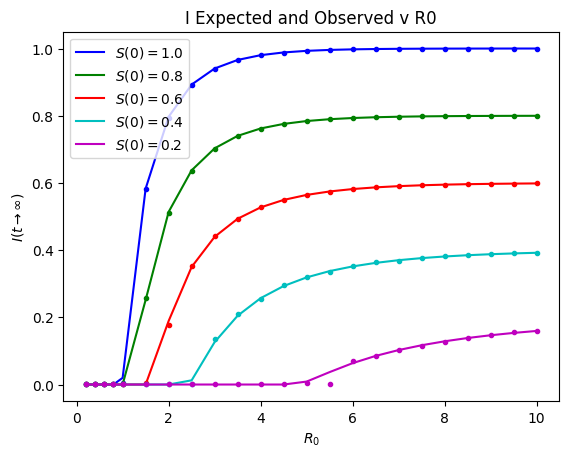

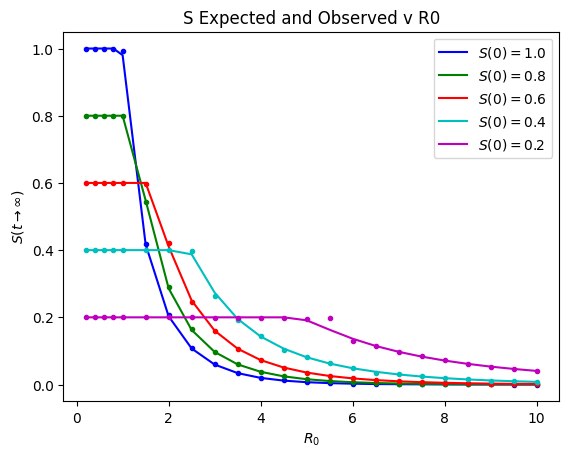

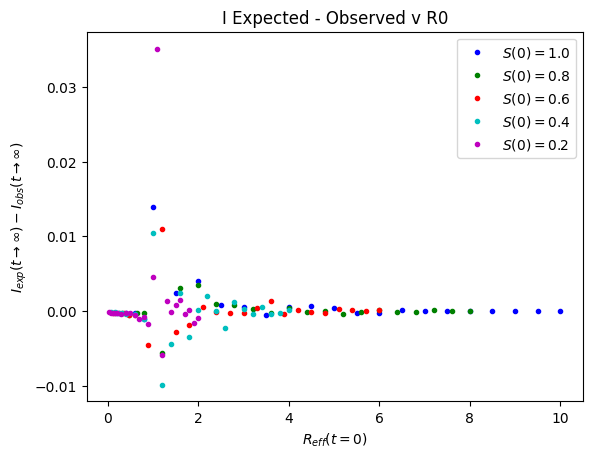

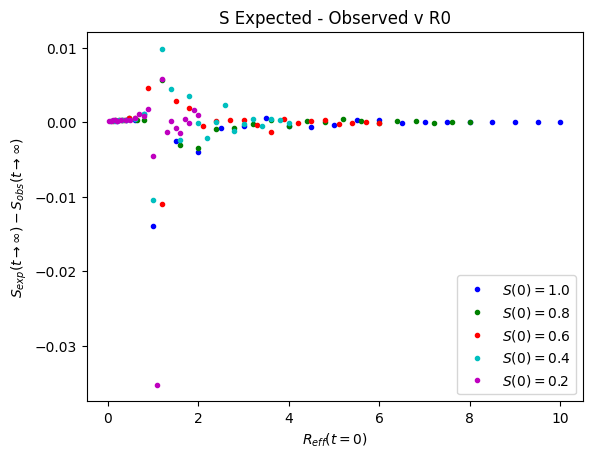

In [8]:
plt.figure()
colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])
for S0 in S0s:
    condition = output["S0"] == S0
    color = next(colors)
    plt.plot(output[condition]["R0"], output[condition]["I_inf_exp"], color=color)
    plt.plot(output[condition]["R0"], output[condition]["I_inf_obs"], ".", label="_nolegend_", color=color)
plt.xlabel("$R_{0}$")
plt.ylabel("$I(t \\rightarrow {\\infty})$")
plt.legend(["$S(0) = 1.0$", "$S(0)= 0.8$", "$S(0) = 0.6$", "$S(0) = 0.4$", "$S(0) = 0.2$"])
plt.title("I Expected and Observed v R0")

plt.figure()
colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])
for S0 in S0s:
    condition = output["S0"] == S0
    color = next(colors)

    plt.plot(output[condition]["R0"], output[condition]["S_inf_exp"], color=color)
    plt.plot(output[condition]["R0"], output[condition]["S_inf_obs"], ".", label="_nolegend_", color=color)
plt.xlabel("$R_{0}$")
plt.ylabel("$S(t \\rightarrow {\\infty})$")
plt.legend(["$S(0) = 1.0$", "$S(0)= 0.8$", "$S(0) = 0.6$", "$S(0) = 0.4$", "$S(0) = 0.2$"])
plt.title("S Expected and Observed v R0")

plt.figure()
colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])
for S0 in S0s:
    condition = output["S0"] == S0
    color = next(colors)

    plt.plot(
        output[condition]["R0"] * S0,
        (output[condition]["I_inf_exp"] - output[condition]["I_inf_obs"]),
        ".",
        label=f"Observed S0={S0}",
        color=color,
    )
plt.xlabel("$R_{eff}(t=0)$")
plt.ylabel("$I_{exp}(t \\rightarrow {\\infty}) - I_{obs}(t \\rightarrow {\\infty})$")
plt.legend(["$S(0) = 1.0$", "$S(0)= 0.8$", "$S(0) = 0.6$", "$S(0) = 0.4$", "$S(0) = 0.2$"])
plt.title("I Expected - Observed v R0")

plt.figure()
colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])

for S0 in S0s:
    condition = output["S0"] == S0
    color = next(colors)

    plt.plot(
        output[condition]["R0"] * S0,
        (output[condition]["S_inf_exp"] - output[condition]["S_inf_obs"]),
        ".",
        label=f"Observed S0={S0}",
        color=color,
    )
plt.xlabel("$R_{eff}(t=0)$")
plt.ylabel("$S_{exp}(t \\rightarrow {\\infty}) - S_{obs}(t \\rightarrow {\\infty})$")
plt.legend(["$S(0) = 1.0$", "$S(0)= 0.8$", "$S(0) = 0.6$", "$S(0) = 0.4$", "$S(0) = 0.2$"])
plt.title("S Expected - Observed v R0")

In [9]:
print(
    "S expected - S observed < 0.05: " + str((np.isclose(output["S_inf_exp"], output["S_inf_obs"], atol=0.05)).all())
)  # Account for 1 timestep offset here
print(
    "I expected - I observed < 0.05: " + str((np.isclose(output["I_inf_exp"], output["I_inf_obs"], atol=0.05)).all())
)  # Account for 1 timestep offset here

S expected - S observed < 0.05: True
I expected - I observed < 0.05: True
